In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
#!{"ros2 run local_planning_performance_modelling compute_metrics -s"}

In [3]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.marker'] = 'o'

fg_color = 'white'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['text.color'] = fg_color
plt.rcParams['ytick.color'] = fg_color
plt.rcParams['xtick.color'] = fg_color
plt.rcParams['axes.labelcolor'] = fg_color
plt.rcParams['axes.edgecolor'] = fg_color

bg_color = "#323a48"
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
plt.rcParams['legend.facecolor'] = bg_color

In [4]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into alpha_1..4
results_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'alpha_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]
odometry_metrics = [c for c in metrics if 'odometry_error_alpha_' in c]
odometry_mean_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_mean' in c]
odometry_std_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_std' in c]
odometry_parameters = [f'alpha_{i}' for i in range(1, 5)]
localization_update_metrics = [c for c in metrics if 'localization_update_' in c]
localization_update_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_mean' in c]
localization_update_translation_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_translation_' in c and '_mean' in c]
navigation_metrics = [c for c in metrics if c in ['trajectory_length', 'execution_time', 'success_rate']]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in run_parameters:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g}]")

## Number of Runs

    1837

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl']

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    robot_model                                                            ['hunter', 'turtle']

    run_index                                                              [0, 1]

    alpha_1                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_2                                                                [0.0]

    alpha_3                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_4                                                                [0.0]

## Metrics

    controller_cpu_time                                                    min:       0.82             avg:      117.9             max:       1031]

    planner_cpu_time                                                       min:       0.32             avg:      32.72             max:      317.3]

    system_cpu_time                                                        min:       3.27             avg:      163.8             max:       1303]

    controller_max_memory                                                  min:      22.73             avg:      62.31             max:      78.79]

    planner_max_memory                                                     min:      25.05             avg:       1193             max:  3.109e+04]

    system_max_memory                                                      min:      137.6             avg:       1380             max:  3.126e+04]

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length                                                      min:          0             avg:      19.61             max:      133.9]

    trajectory_length_version                                              [1]

    execution_time                                                         min:      0.294             avg:      88.16             max:      648.1]

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.6228             max:          1]

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   1.43e-17             avg:     0.0619             max:      4.194]

    odometry_error_alpha_1_std                                             min:          0             avg:    0.09467             max:       13.9]

    odometry_error_alpha_2_mean                                            min:  4.546e-18             avg:    0.08054             max:      9.154]

    odometry_error_alpha_2_std                                             min:          0             avg:     0.1485             max:      18.24]

    odometry_error_alpha_3_mean                                            min:  2.061e-17             avg:    0.05954             max:     0.8207]

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01594             max:      1.417]

    odometry_error_alpha_4_mean                                            min:  1.629e-17             avg:     0.2319             max:      1.091]

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2276             max:      1.809]

    odometry_error_version                                                 [2]

    localization_update_absolute_translation_error_mean                    min:   0.001657             avg:     0.1001             max:      1.698]

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.04982             max:      1.557]

    localization_update_absolute_rotation_error_mean                       min:  0.0003956             avg:     0.0267             max:      1.145]

    localization_update_absolute_rotation_error_std                        min:          0             avg:    0.04004             max:      1.299]

    localization_update_relative_translation_error_mean                    min:   0.001501             avg:     0.0112             max:    0.05948]

    localization_update_relative_translation_error_std                     min:          0             avg:    0.01059             max:     0.4555]

    localization_update_relative_rotation_error_mean                       min:  0.0002547             avg:    0.01072             max:     0.3784]

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.03476             max:     0.6973]

    localization_update_normalized_relative_translation_error_mean         min:    0.00547             avg:    0.06296             max:       1.29]

    localization_update_normalized_relative_translation_error_std          min:          0             avg:    0.07965             max:      9.121]

    localization_update_normalized_relative_rotation_error_mean            min:   0.005356             avg:     0.1689             max:      12.29]

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:     0.7821             max:      43.93]

    localization_update_error_version                                      [1]

    localization_update_rate_mean                                          min:     0.3642             avg:      1.157             max:       37.4]

    localization_update_rate_std                                           min:          0             avg:     0.6343             max:      14.34]

    localization_update_rate_version                                       [1]

In [5]:
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg'])[navigation_metrics].agg(['mean', 'count'])

trajectory_length       execution_time       success_rate      
                                                                   mean count           mean count         mean count
robot_model local_planner_node max_steering_angle_deg                                                                
hunter      teb                20.000                            16.463   305         88.457   305        0.402   306
                               40.000                            14.344   304         75.039   304        0.380   305
turtle      dwb                90.000                            24.067   150         99.003   150        0.993   150
            rpp                90.000                            29.448   150         83.395   150        0.636   151
            teb                20.000                            24.457   313        117.334   313        0.725   313
                               40.000                            23.109   312        102.702   312        0.843   313
                               90.000                            12.184   295         51.923   295        0.565   299

Mean: 19.61087570396879


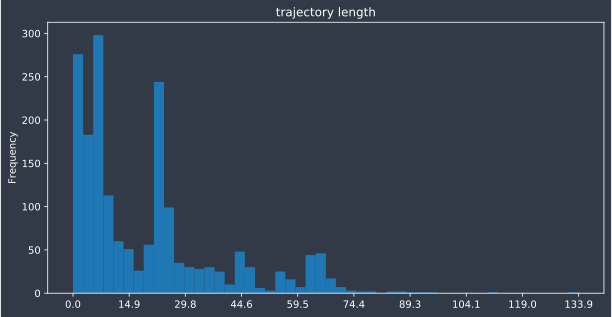

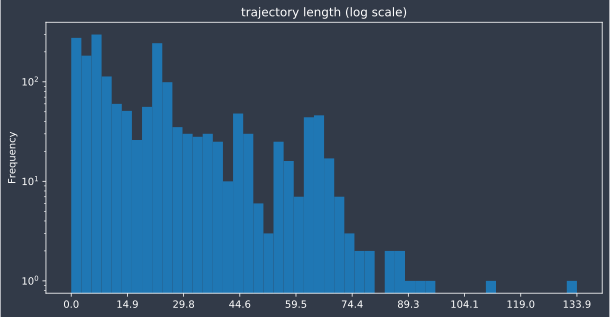

In [6]:
p = df.trajectory_length
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

Mean: 88.15569655549483


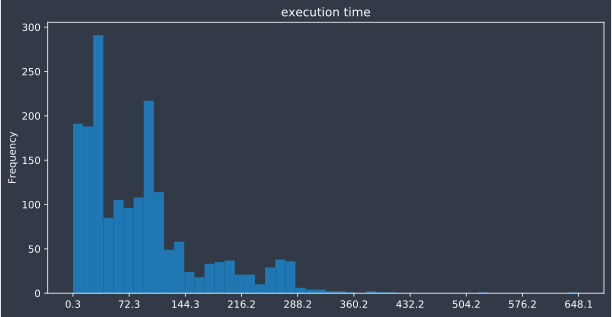

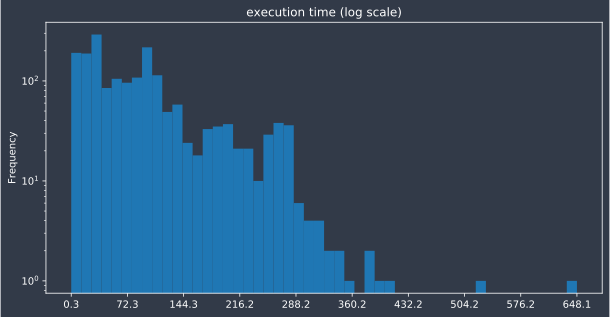

In [7]:
p = df.execution_time
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

mean  count
robot_model local_planner_node global_planner_node             
turtle      dwb                navfn               0.993    150
            teb                navfn               0.918    464
            rpp                navfn               0.636    151
hunter      teb                navfn               0.616    297
turtle      teb                smac                0.508    461
hunter      teb                smac                0.178    314

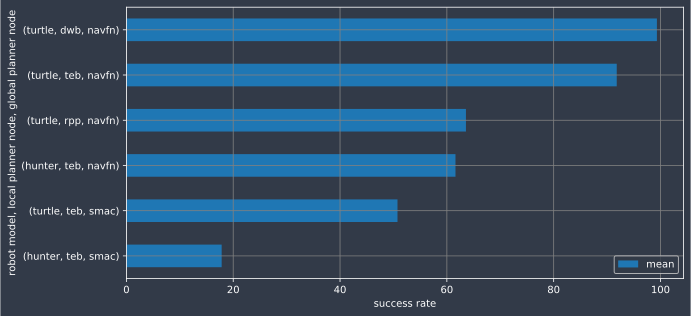

In [8]:
success_rate_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])['success_rate'].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
ax = (success_rate_df.sort_values(by=('mean'), ascending=True)*100).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True)
ax.set_xlabel("success rate")
ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
success_rate_df

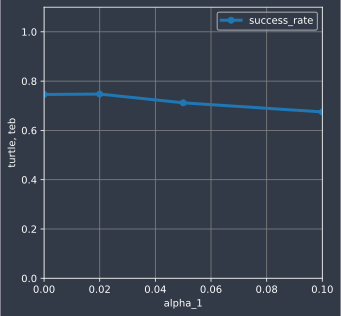

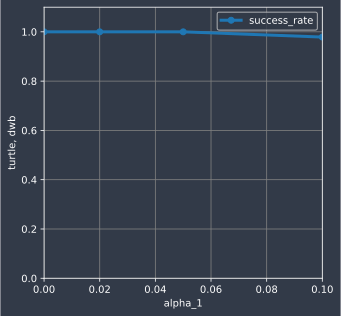

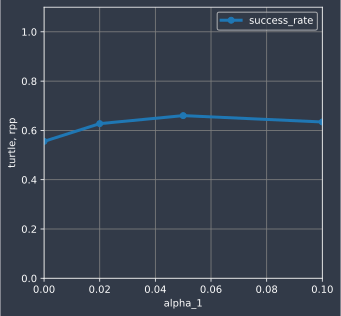

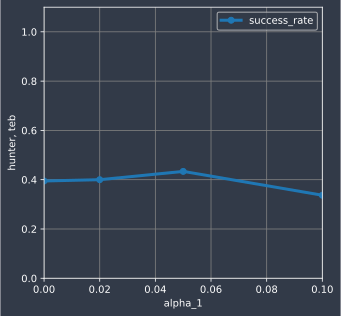

In [9]:
for robot_model in df.robot_model.unique():
    for local_planner_node in df.local_planner_node.unique():
        if len(df[(df.local_planner_node == local_planner_node) & (df.robot_model == robot_model)]):
            df[(df.local_planner_node == local_planner_node) & (df.robot_model == robot_model)].groupby('alpha_1').success_rate.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
            plt.legend()
            plt.ylabel(f"{robot_model}, {local_planner_node}")
            plt.ylim([0, 1.1])
            plt.show()

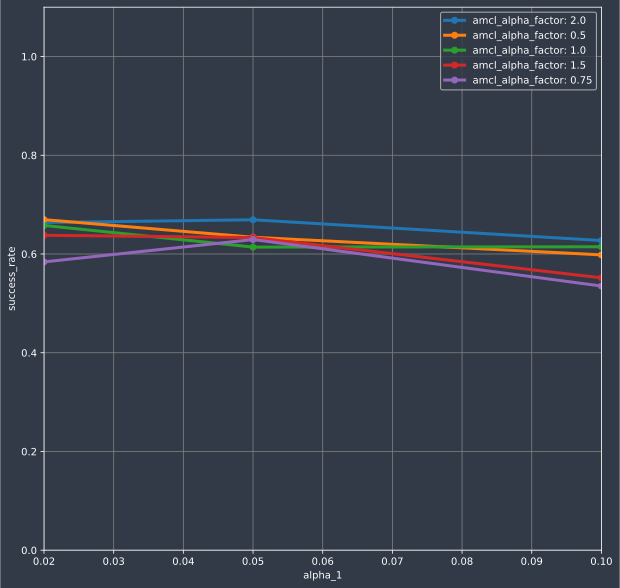

In [10]:
for amcl_alpha_factor in df[df.amcl_alpha_factor > 0].amcl_alpha_factor.unique():
    df[df.amcl_alpha_factor == amcl_alpha_factor].groupby('alpha_1').success_rate.mean().plot(x='alpha_1', label=f"amcl_alpha_factor: {amcl_alpha_factor}", grid=True)
    plt.legend()
#     plt.ylabel(f"amcl_alpha_factor: {amcl_alpha_factor}")
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

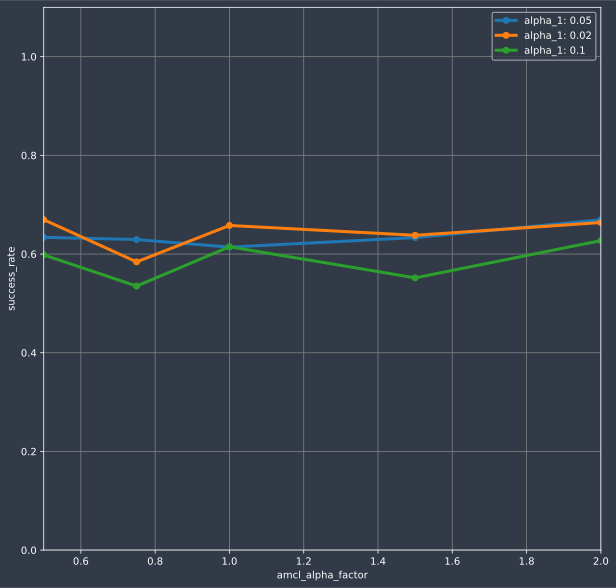

In [11]:
for alpha_1 in df[df.amcl_alpha_factor > 0].alpha_1.unique():
    df[df.alpha_1 == alpha_1].groupby('amcl_alpha_factor').success_rate.mean().plot(x='amcl_alpha_factor', label=f"alpha_1: {alpha_1}", grid=True)
    plt.legend()
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

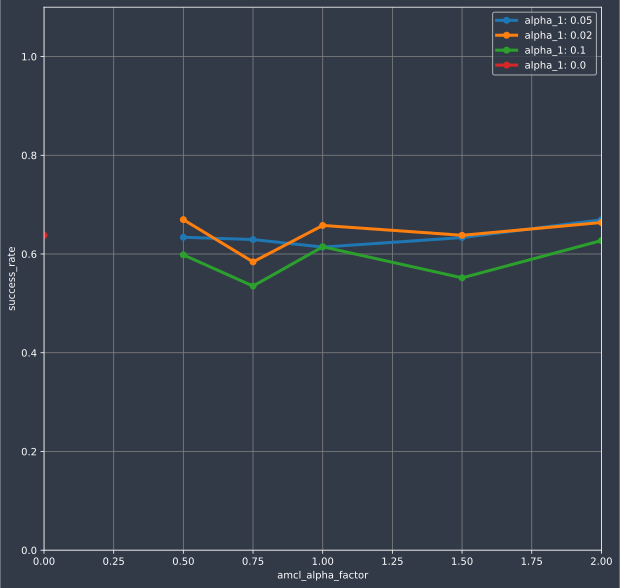

In [12]:
for alpha_1 in df.alpha_1.unique():
    df[df.alpha_1 == alpha_1].groupby('amcl_alpha_factor').success_rate.mean().plot(x='amcl_alpha_factor', label=f"alpha_1: {alpha_1}", grid=True)
    plt.legend()
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

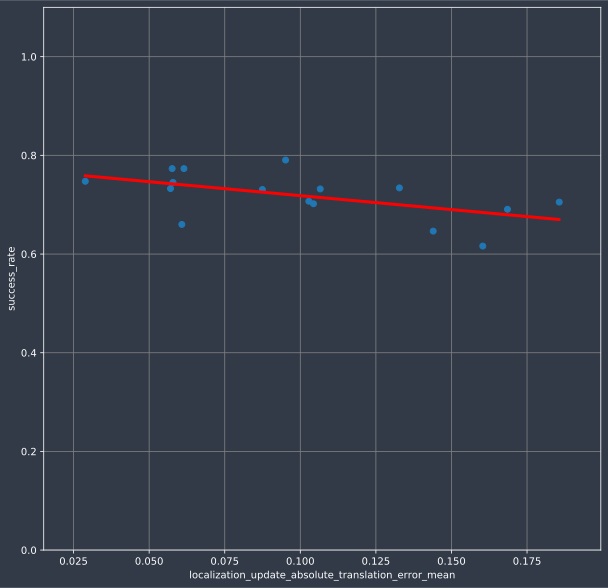

In [13]:
df_lr = df[df.localization_update_absolute_translation_error_mean.notna() & df.success_rate.notna()].groupby(['alpha_1', 'amcl_alpha_factor']).mean()
X = df_lr.localization_update_absolute_translation_error_mean.values.reshape(-1, 1)  # values converts it into a numpy array
Y = df_lr.success_rate.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, '-', color='red')

plt.grid()
plt.xlabel('localization_update_absolute_translation_error_mean')
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

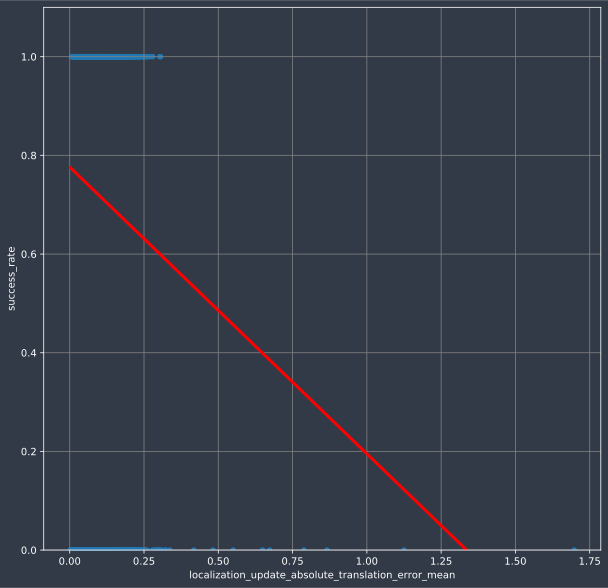

In [14]:
df.plot.scatter(x='localization_update_absolute_translation_error_mean', y='success_rate', grid=True)

df_lr = df[df.localization_update_absolute_translation_error_mean.notna() & df.success_rate.notna()]
X = df_lr.localization_update_absolute_translation_error_mean.values.reshape(-1, 1)  # values converts it into a numpy array
Y = df_lr.success_rate.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, '-', color='red')

# plt.legend()
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

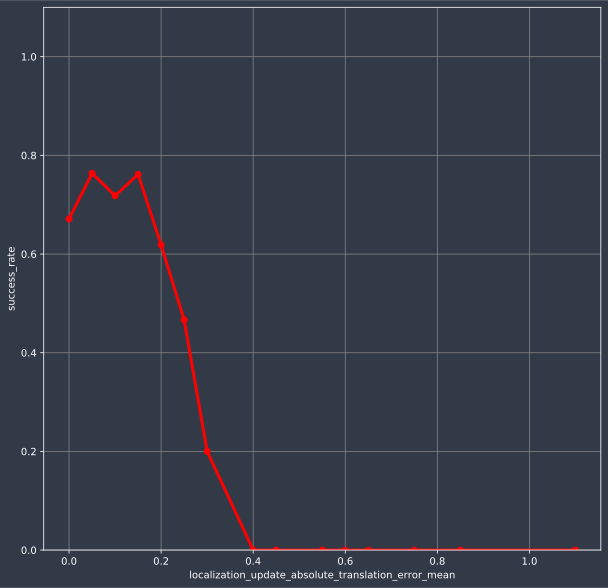

In [57]:
bins = np.arange(0., df.localization_update_absolute_translation_error_mean.max(), .05)
df_lr = df[df.localization_update_absolute_translation_error_mean.notna() & df.success_rate.notna()].copy()
df_lr['x_range'] = pd.cut(df_lr.localization_update_absolute_translation_error_mean, bins, labels=bins[:-1]).astype('float')

df_lr_g = df_lr.groupby('x_range').mean()

# df_lr['x_range'] = df_lr['x_range'].astype('float')

X = df_lr_g.index.values.reshape(-1, 1)  # values converts it into a numpy array
Y = df_lr_g.success_rate.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
# linear_regressor = LinearRegression()  # create object for the class
# linear_regressor.fit(X, Y)  # perform linear regression
# Y_pred = linear_regressor.predict(X)  # make predictions

plt.plot(X, Y, color='red')
# plt.plot(X, Y_pred, '-', color='red')

plt.grid()
plt.xlabel('localization_update_absolute_translation_error_mean')
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()